In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import pickle

import scipy
from scipy.stats import ttest_ind_from_stats as ttest
from sklearn import metrics

## Politic Analysis

In [3]:
import sys
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#sparkql query to get the country name and their respective quids from wikidata
query = """#List of present-day countries and capital(s)
SELECT DISTINCT ?country ?countryLabel
WHERE
{
  ?country wdt:P31 wd:Q3624078 .

  SERVICE wikibase:label { bd:serviceParam wikibase:language "en" }
}
ORDER BY ?countryLabel"""

'''
query internet dataset:
endpoint_url (string): url of corresponding dataset
query (string): sparksql query
'''
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (sys.version_info[0], sys.version_info[1])
    # TODO adjust user agent; see https://w.wiki/CX6
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()


results = get_results(endpoint_url, query)

#Build a country dictionnary {quid, country name}
country_dict = {}
for result in results["results"]["bindings"]:
    country_id = result["country"]['value'].split('/')[-1]
    country_dict[country_id] = result["countryLabel"]['value']
# country_dict.to_pickle('data/country_dict.bz2', compression="bz2")

In [2]:
path_us = 'data/'

politician_id = 'Q82955'
cols_of_interest = ['quoteID', 'speaker', 'qids', 'sentiment']


In [4]:

dfs = []

for i in range(2015, 2021):
    #Loading the dataset : the quotes and also the weighted sentiment
    df_full = pd.read_pickle(path_us + "us_" + str(i) + ".pkl.bz2",compression='bz2')[cols_of_interest]
    df_sent = pd.read_pickle(path_us + "us_weighted_sent_" + str(i) + '.pkl.bz2',compression='bz2')
    print("length df_sent: ",len(df_sent))
    #Merge the quotes with their respective weighted sentiment
    df_all = pd.merge(df_full.copy(), df_sent.copy(), left_on=['quoteID'], right_on=['quoteID'], how='inner')
    
    dfs.append(df_all.copy())
    print(str(i) + " loaded, length ",len(df_all))
    df_full = None
    df_all =None
    df_sent = None

length df_sent:  626278
2015 loaded, length  626278
length df_sent:  571920
2016 loaded, length  571920
length df_sent:  1004632
2017 loaded, length  1004632
length df_sent:  989231
2018 loaded, length  989231
length df_sent:  818838
2019 loaded, length  818838
length df_sent:  219947
2020 loaded, length  219947


In [5]:
#Load speaker attributes
speaker_df = pd.read_parquet("data/speaker_attributes.parquet")
speaker_df.drop(columns=['aliases',
       'lastrevid', 
       'US_congress_bio_ID', 'party',
       'label', 'candidacy', 'type'], inplace=True)

In [34]:
'''
Get the most probable quid of the speaker
'''
def process_qids(x):
    if not x:
        return ["None"]
    return x[0]

dfs_new = []
for df in dfs :
    print(i)
    print("before , length : ",len(df))
    
    df["speaker_id"] = df.qids.map(process_qids).copy()
    #Drop quid column
    df.drop(columns=['qids'],inplace=True)
    #Merge our dataset with the speaker attributes
    df_1 = pd.merge(df.copy(), speaker_df, left_on=['speaker_id'], right_on=['id'], how='inner')
    print("length df1: ",len(df_1))
    
    #Map each nationality quid with it string value
    df_1 = df_1.explode('nationality')
    df_1.nationality = df_1.nationality.map(country_dict)
    
    #Add column if the person is involved in politic or not
    df_1.occupation.fillna(value="None", inplace=True)
    df_1['politician'] = df_1['occupation'].map(lambda x : politician_id in x)
    print("length df1 after_process: ",len(df_1))
    
    dfs_new.append(df_1.copy())
    
    df_1 = None
    df = None


before , length :  626278
length df1:  404582
length df1 after_process:  428307
before , length :  571920
length df1:  356108
length df1 after_process:  373922
before , length :  1004632
length df1:  616161
length df1 after_process:  648315
before , length :  989231
length df1:  611988
length df1 after_process:  643144
before , length :  818838
length df1:  512795
length df1 after_process:  536718
before , length :  219947
length df1:  138204
length df1 after_process:  144148


In [ ]:
#Temporary store 
file_name = 'temp/politic.pkl'
open_file = open(file_name, "wb")

pickle.dump(dfs_new, open_file)

open_file.close()

### After processing

In [4]:
file_name = 'temp/politic.pkl'

In [5]:
with open(file_name, 'rb') as f:
    dfs_new = pickle.load(f)

In [6]:
#Computing the ratio and percentage of politicians
for (ind, df) in enumerate(dfs_new) : 
    print('Year ',(ind + 2015))
    print('=============================================================')
    ratio_q = len(df[df.politician == True]) / float(len(df))
    print("Percentage of politician's quotes :  " + str(ratio_q * 100) + "%")
    
    ratio_p = len(df[df.politician == True]['speaker_l'].unique()) / float(len(df['speaker_l'].unique()))
    print("Ratio of politicians  " + str(ratio_p * 100) + "%")

Year  2015
Percentage of politician's quotes :  38.085065151865365%
Ratio of politicians  12.690181559995942%
Year  2016
Percentage of politician's quotes :  40.99063441038505%
Ratio of politicians  13.961380740647636%
Year  2017
Percentage of politician's quotes :  39.72050623539483%
Ratio of politicians  13.03395754228512%
Year  2018
Percentage of politician's quotes :  38.250376276541495%
Ratio of politicians  13.131521963852407%
Year  2019
Percentage of politician's quotes :  41.78302199665374%
Ratio of politicians  13.208870873445843%
Year  2020
Percentage of politician's quotes :  46.01381913033826%
Ratio of politicians  16.108126841102063%


### Discussion
As a first remark, one can observe that in overall, always more than one third of the quotes are from politicians, and the percentage of politicians more than 1 people over 10. It shows that the quotes are undoubtly not evenly distributed over each profession, leading to a potential source of bias if we compare the quotation dataset and the PEW one.

In [5]:
'''
Compute the mean of a given country
'''
def compute_mean(df_country):
    #Use the weighted sentiment
    mean = df_country.weighted_sentiment.mean()
    df_mean = pd.DataFrame()
    df_mean["mean"] = mean
    df_mean['country'] = mean.index
    return df_mean


In [12]:
df_all = None 
#Add year column to concat all the years
for (ind, df) in enumerate(dfs_new):
    df['year'] = ind + 2015

df_all = pd.concat(dfs_new)[['nationality', 'sentiment', 'weighted_sentiment','politician', 'year']]

In [24]:
df_all.columns

Index(['nationality', 'sentiment', 'weighted_sentiment', 'politician', 'year'], dtype='object')

In [43]:
#Create mask to detect if politician or not
pol_msk = df_all.politician == True

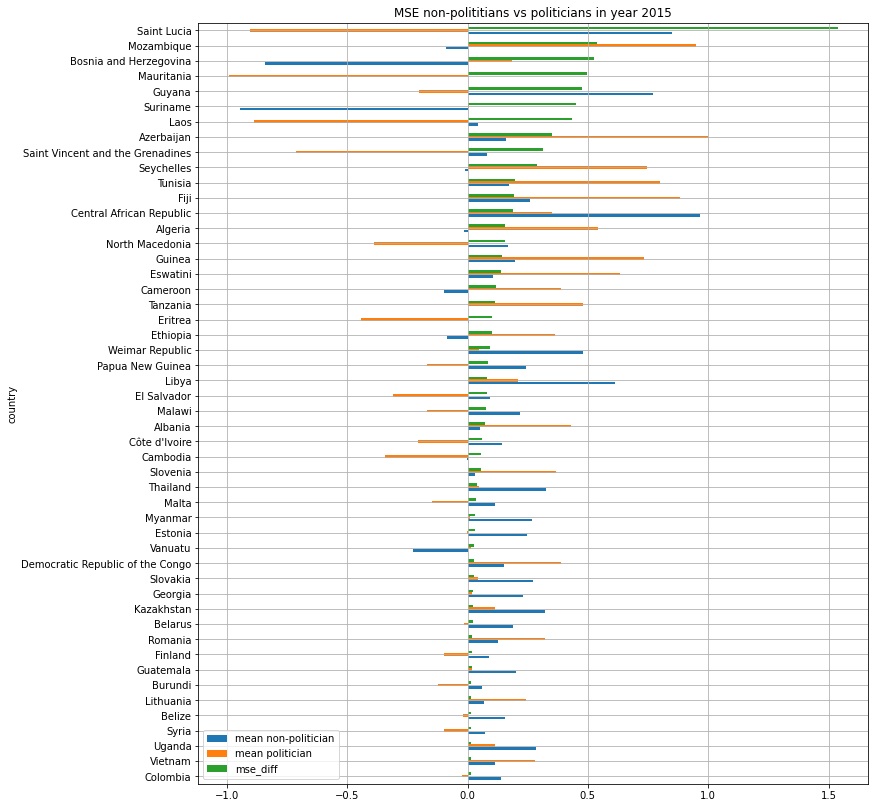

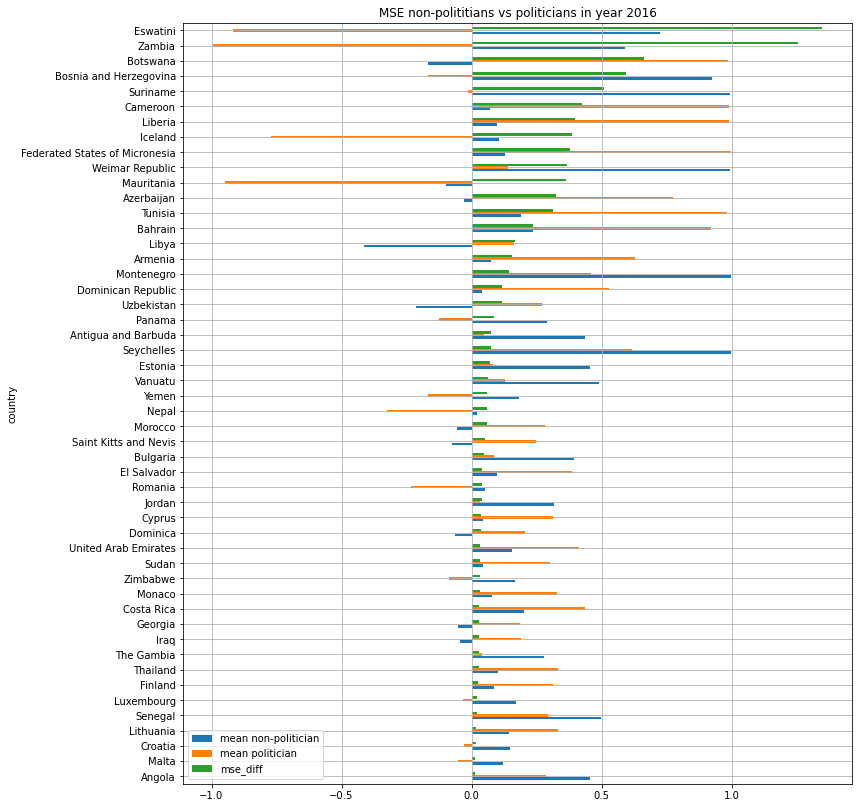

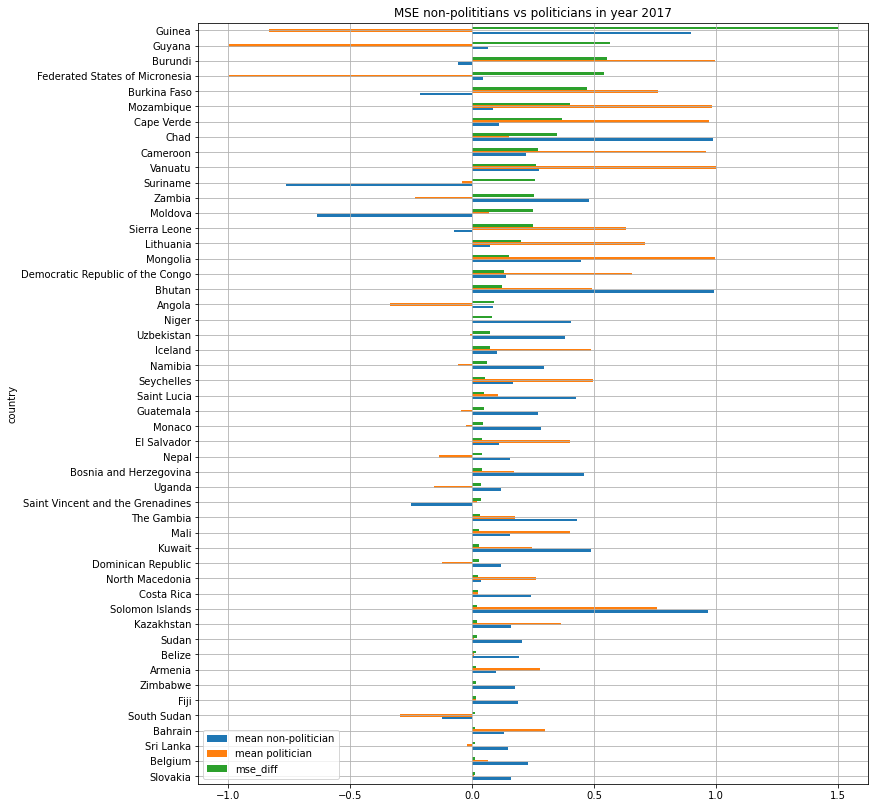

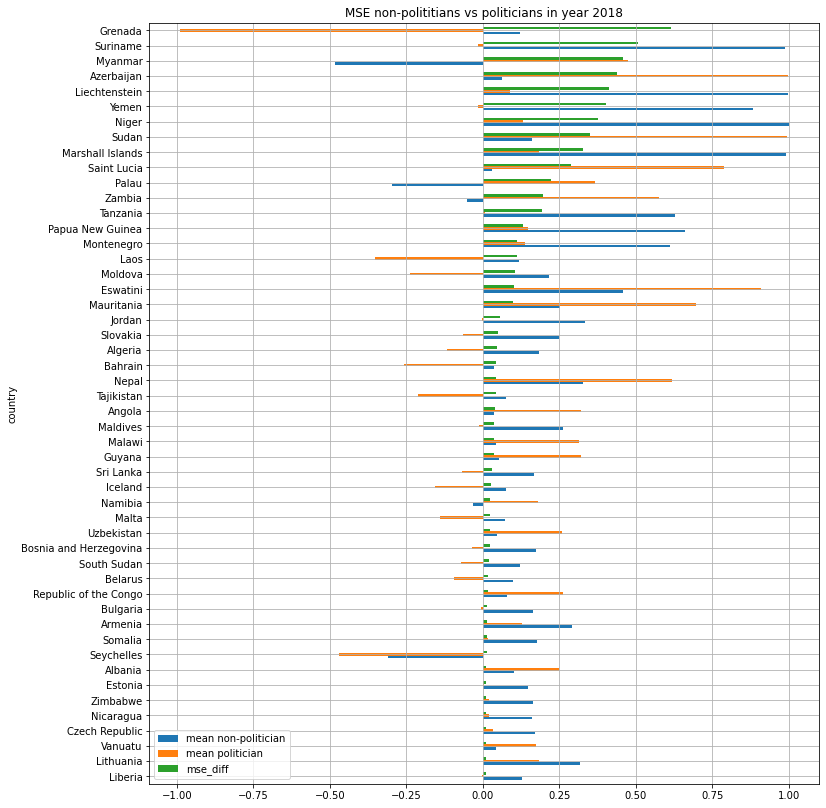

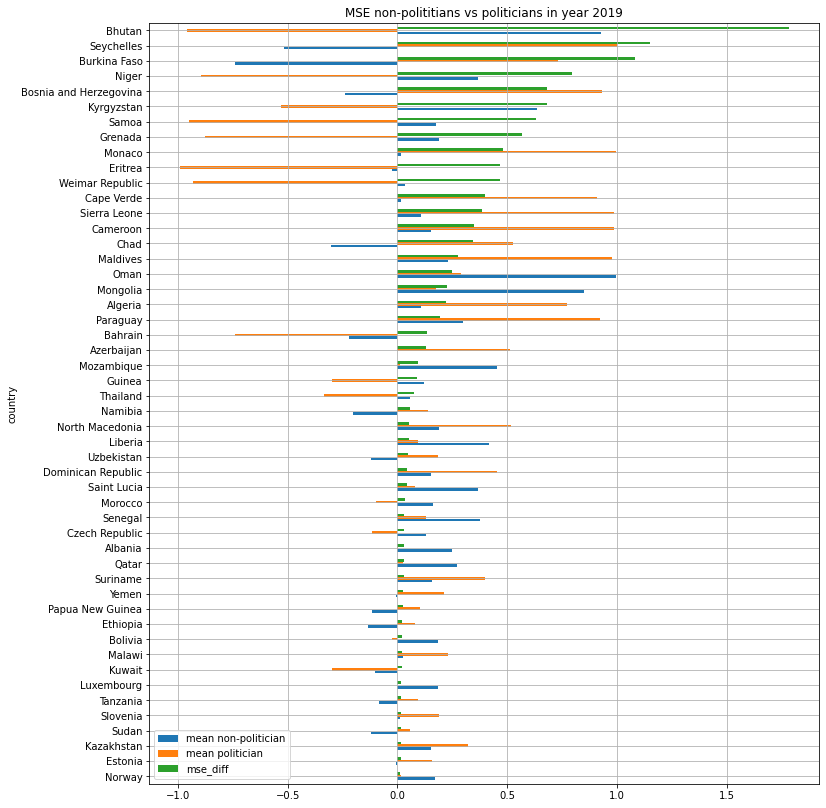

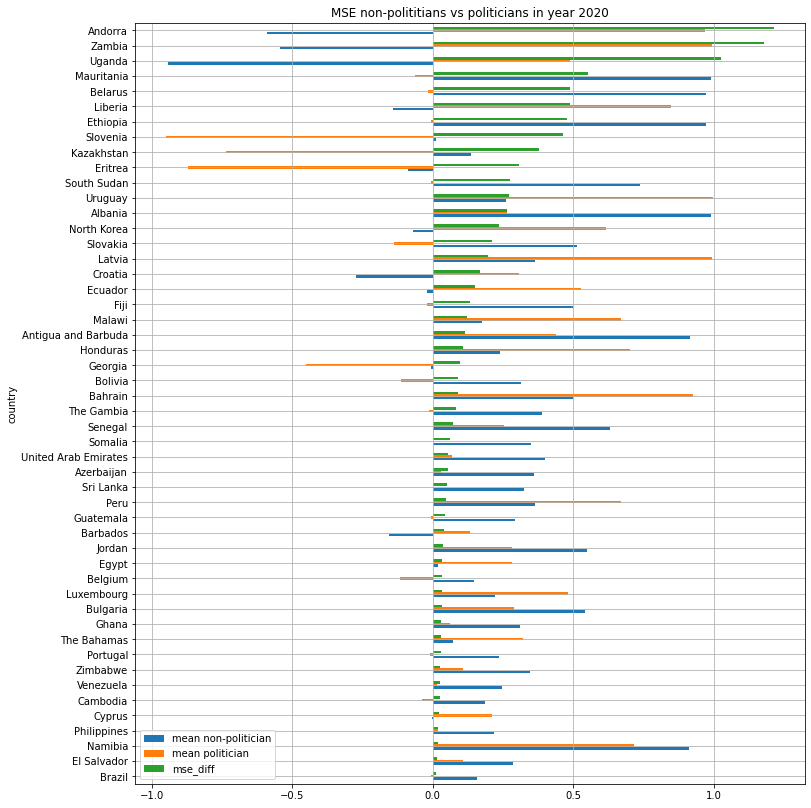

In [6]:
#List to store the countries with highest difference between politicians or non-politicians
highest_diff = []
#Threshold of when a MSE value is considered to high when comparing both
thres_diff = 0.25
for (ind, df) in enumerate(dfs_new) :
    #Groupby nationality
    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    #Comput mean
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)
    #Merge politician and non-politician dataset for each country
    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))
    #Compute the MSE between oliticians or non-politicians
    temp_df['mse_diff'] = 1/2 * np.abs(temp_df['mean politician'] - temp_df['mean non-politician'])**2
    temp_df.sort_values('mse_diff',  ascending= True,inplace = True)
    #Plot only the 50 countries with highest MSE value
    temp_df.tail(50).plot(x= 'country', figsize=(12,14), kind='barh')
    plt.title("MSE non-polititians vs politicians in year " + str(ind + 2015))
    plt.grid()
    plt.show()
    #Add countries with highest MSE value 
    highest_diff += temp_df[temp_df.mse_diff > thres_diff]['country'].tolist()

In [7]:
#Get the number of times a country appears in the top differences
diff_dict = {i:highest_diff.count(i) for i in highest_diff}
diff_dict = dict(sorted(diff_dict.items(), key=lambda item: item[1], reverse= True))
{k: v for k, v in diff_dict.items() if  v > 1}

{'Suriname': 4,
 'Azerbaijan': 3,
 'Mauritania': 3,
 'Bosnia and Herzegovina': 3,
 'Cameroon': 3,
 'Zambia': 3,
 'Seychelles': 2,
 'Guyana': 2,
 'Mozambique': 2,
 'Saint Lucia': 2,
 'Weimar Republic': 2,
 'Federated States of Micronesia': 2,
 'Liberia': 2,
 'Chad': 2,
 'Cape Verde': 2,
 'Burkina Faso': 2,
 'Niger': 2,
 'Grenada': 2,
 'Eritrea': 2}

### Pew comparison

In [18]:
import pyreadstat

In [19]:
column_names = ['country', 'fav_us', 'sex', 'age']

In [20]:
columns = {2015: ['COUNTRY', 'Q12A', 'Q145', 'Q146'], 
           2016: ['country', 'Q10A', 'q107', 'q108'], 
           2017: ['Country', 'fav_US', 'sex', 'age'], 
           2018: ['COUNTRY', 'fav_US', 'sex', 'age'], 
           2019: ['country', 'FAV_US', 'SEX', 'AGE'], 
           2020: ['country', 'fav_US', 'sex', 'age']}

In [21]:
#extract pew dataset
pew = pd.read_csv('data/pew.csv')

#List of "invalid" answers in pew dataset
Nan_keywords = ['Refused', 'Don’t know', 'Don’t know (DO NOT READ)', 'Refused (DO NOT READ)',
       '(VOL) Refused', "(VOL)\xa0Don't know"]

pew = pew.replace(to_replace=Nan_keywords, value=np.NaN)

#map "sentiment" to float values
fav_dict = {'Somewhat favorable': 0.25, 'Very favorable':1,
       'Somewhat unfavorable':-0.25, 'Very unfavorable':-1}

pew = pew.replace(fav_dict)

In [12]:
pew.columns

Index(['country', 'fav_us', 'sex', 'age', 'year'], dtype='object')

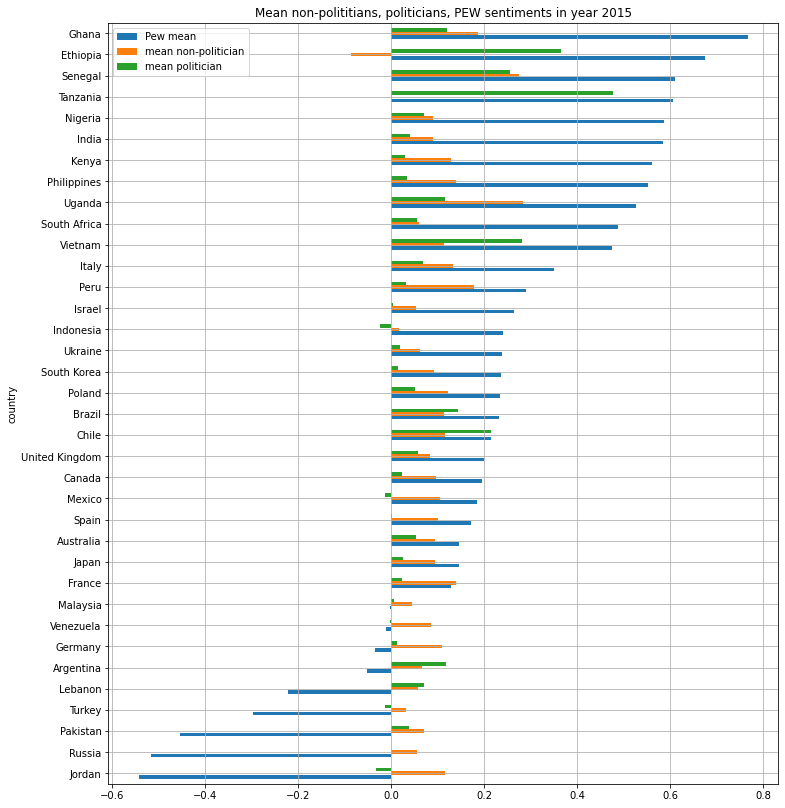

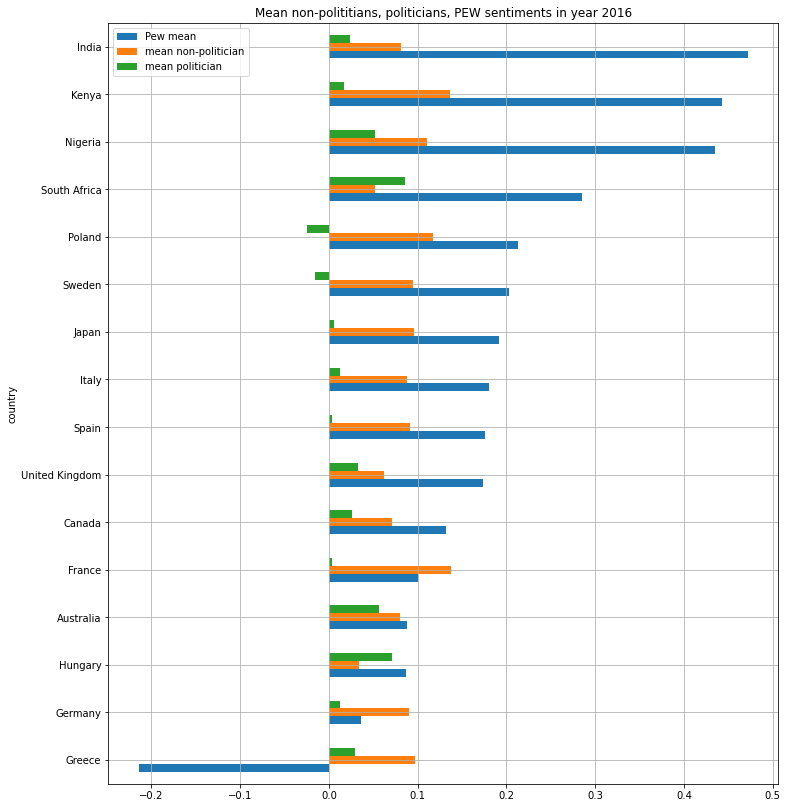

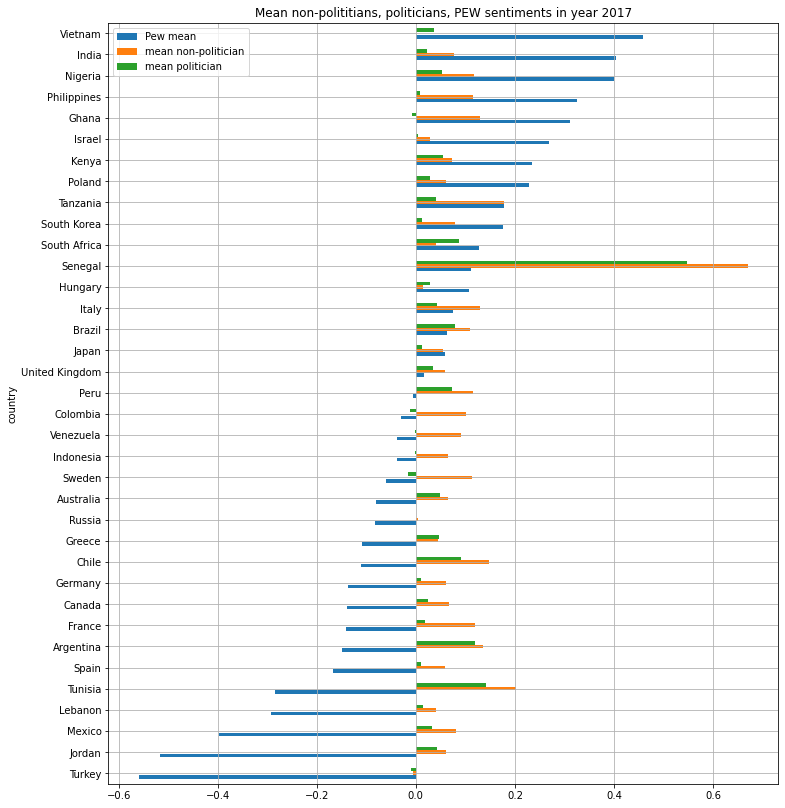

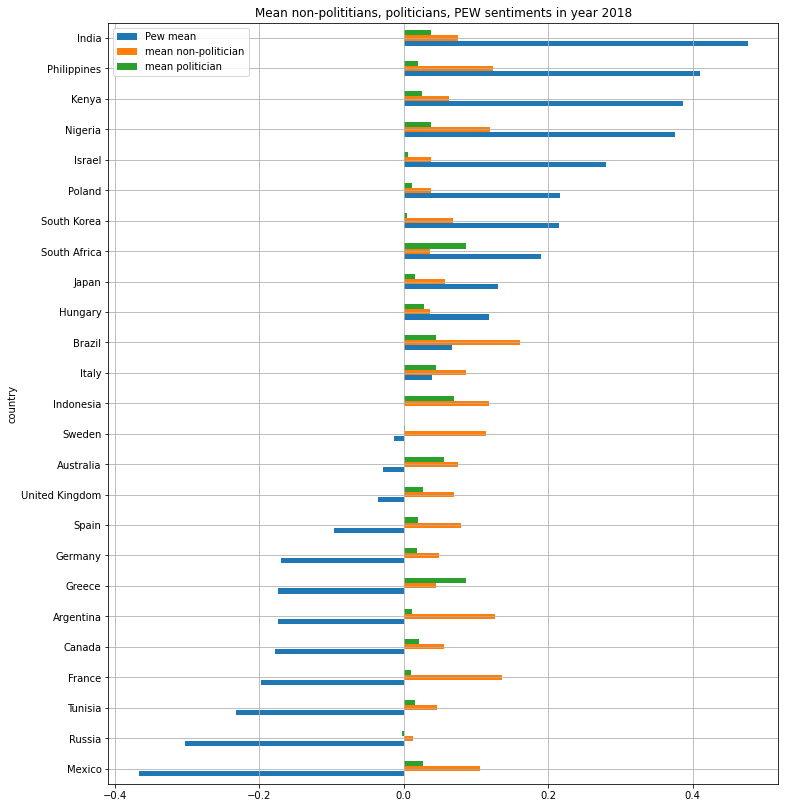

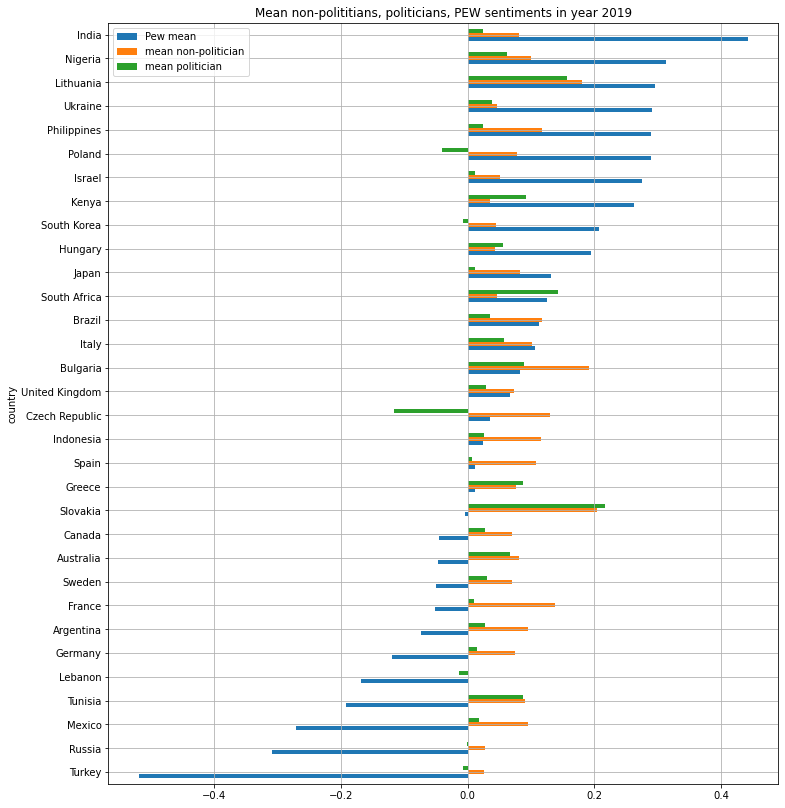

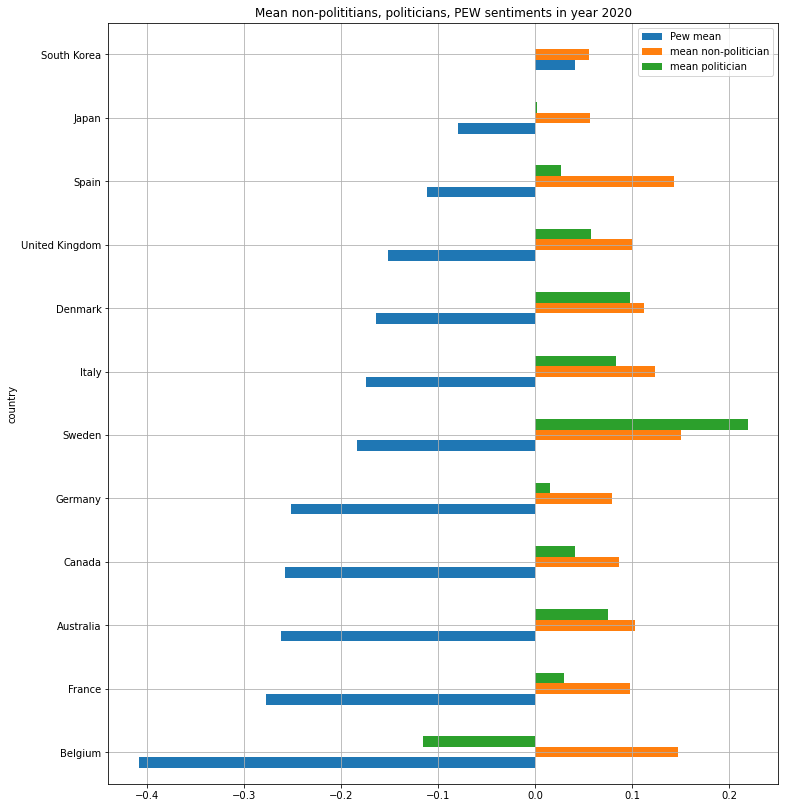

In [14]:

for (ind, df) in enumerate(dfs_new) :
    #Groupby nationaliy
    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    #Compute mean
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)
    pew_fav_us = pew[pew.year == (ind + 2015)].groupby('country')['fav_us'].mean().reset_index(name='Pew mean')
    #Merge non-politician and politician dataset
    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))
    #Merge the pew dataset with result of previous
    temp_df = pd.merge(left=pew_fav_us, right=temp_df, left_on='country', right_on='country')

    temp_df.sort_values('Pew mean',  ascending= True,inplace = True)
    #Plot mean of the 3 datasets
    temp_df.plot(x= 'country', figsize=(12,14), kind='barh')
    plt.title("Mean non-polititians, politicians, PEW sentiments in year " + str(ind + 2015))
    plt.grid()
    plt.show()

### Discussion
At first sight, there are important differences between the Pew and the quotes sentiments. The difference between at first glance not so marked, we will see after more in depth this part. In overall, the Pew dataset sentiment are without a doubt more constrasted. One should not forget that the PEW values are the direct sentiment of individuals with respect to U.S., in contrary to the quotations that have been collected from newspapers : for a significant amount of them, they are just informations about the United States and not about the speaker's opinion of the U.S.A..  

In [16]:
#List of MSE results for each year for the non-politician dataframe (w.r.t. to Pew)
mse_years_non_p = []
#List of MSE results for each year for the politician dataframe (w.r.t. to Pew)
mse_years_p = []
for (ind, df) in enumerate(dfs_new) :
    #Groupby nationaliy
    df_country_non_p = df[~pol_msk].groupby("nationality")
    df_country_p = df[pol_msk].groupby("nationality")
    #Compute mean
    df_mean_non_p = compute_mean(df_country_non_p)
    df_mean_p = compute_mean(df_country_p)
    pew_fav_us = pew[pew.year == (ind + 2015)].groupby('country')['fav_us'].mean().reset_index(name='Pew mean')
    #Merge non-politician and politician dataset
    temp_df = pd.merge(left=df_mean_non_p, right=df_mean_p, left_on='country', right_on='country', suffixes=(' non-politician', ' politician'))
    #Merge the pew dataset with result of previous
    temp_df = pd.merge(left=pew_fav_us, right=temp_df, left_on='country', right_on='country')
    
    #Compute MSE
    mse_years_non_p.append(metrics.mean_squared_error(temp_df['Pew mean'], temp_df['mean non-politician']))
    mse_years_p.append(metrics.mean_squared_error(temp_df['Pew mean'], temp_df['mean politician']))



In [17]:
#print MSE results for each year for the non-politician dataframe
mse_years_non_p

[0.11564369079766121,
 0.03575213001417866,
 0.07334061237986574,
 0.05622955515678644,
 0.0425981019011025,
 0.10279673840042548]

In [18]:
#MSE results for each year for the politician dataframe
mse_years_p

[0.10291023288279459,
 0.054146453307127536,
 0.0663429055623694,
 0.05364067845144229,
 0.04247228936453803,
 0.06851675532760973]

In [19]:
#Compare MSE values : True : the non-politician MSE is greater than the politician one
np.array(mse_years_non_p) > np.array(mse_years_p)

array([ True, False,  True,  True,  True,  True])

### Discussion
One has as a result that, computing the MSE for each year between the non-politicians vs Pew and between politicians and Pew, that for both 2015 and 2020 are the highest values. For 2020, there are only a few countries, and for most of them are negative. But only comparing the MSE of the non-politicians and the politicians does not emphasis a huge difference. In fact, most of the years, the politicians point of view are closer to Pew than the non-politician's opinion.

### Note
In the following results, we remove the countries for which there are no 20 different speakers, so that there exists enough diversitiy to compute a more meaningfull t-test.

In [3]:
'''
Compute statistics of the given dataset for each country
If count_diff_speaker=True, we remove the countries for which there are no 20 different speakers
'''
def compute_stats(df, name_group="nationality", name_sent="weighted_sentiment", count_diff_speaker=False):
    #Groupby country + aggregate to get mean, std and size
    stats = df.groupby(name_group)[name_sent].agg(['mean', 'std', 'size'])
    stats['nat'] = stats.index
    if count_diff_speaker :
#       remove the countries for which there are less than 20 different speakers
        threshold = 20
        count_speak = pd.DataFrame()
        count_speak = df.groupby(name_group)['speaker_l'].nunique()
        stats = stats[count_speak > threshold]
    return stats
'''
Compute t-test between to dataframe given their respective mean and variance columns
Returns : p-value
'''
def compute_ttest(df, col1, col2):
    return ttest(df['mean'+col1], df['std'+col1], df['size'+col1],
                 df['mean'+col2], df['std'+col2], df['size'+col2])[1]

In [61]:
#Get the proposition of rejected or not in each different case
prop_p_non_p = 0
prop_p_pew = 0
prop_non_p_pew = 0

#Track of all countries appearing in general
list_overall = set()
#Track of all countries appearing in the non-rejected politicians/non-politicians
list_p_non_p = set()
#Track of all countries appearing in the non-rejected politicians/pew
list_p_pew = set()
#Track of all countries appearing in the non-rejected non-politicians/pew
list_non_p_pew = set()



for (ind, df) in enumerate(dfs_new) :
    #Compute statistics
    df_stats_non_p = compute_stats(df[~pol_msk], count_diff_speaker=True)
    df_stats_p = compute_stats(df[pol_msk], count_diff_speaker=True)
    df_stats_pew = compute_stats(pew[pew.year == (ind + 2015)],
                                 name_group='country', 
                                 name_sent='fav_us')
    
    #Merge all the datasets to get only one dataframe
    stats_df = pd.merge(left=df_stats_non_p, right=df_stats_p, left_on='nat', right_on='nat', suffixes=('_non_p', '_p'))
    stats_df = pd.merge(left=df_stats_pew, right=stats_df, left_on='nat', right_on='nat').set_index('nat')
    
    #Compute the t-test for non-pol/pol, non-pol/pew, pol/pew
    stats_df['p_val_non_p_vs_p'] = compute_ttest(stats_df, col1='_non_p', col2='_p')
    stats_df['p_val_non_p_vs_pew'] = compute_ttest(stats_df, col1='_non_p', col2='')
    stats_df['p_val_p_vs_pew']= compute_ttest(stats_df, col1='_p', col2='')
    #Set significance level to make a statistic decision
    alpha = 0.01
    #Mask of the countries not rejected
    not_rej_msk_1 = (stats_df.p_val_non_p_vs_p) > alpha 
    not_rej_msk_2 = (stats_df.p_val_non_p_vs_pew) > alpha 
    not_rej_msk_3 = (stats_df.p_val_p_vs_pew) > alpha 
    #Update list of countries in each case
    list_overall.update(stats_df.index.values)
    list_p_non_p.update(stats_df[not_rej_msk_1].index.values)
    list_p_pew.update(stats_df[not_rej_msk_2].index.values)
    
    #Adding the number of countries that were not rejected in each case
    prop_p_non_p += len(stats_df[not_rej_msk_1])/float(len(stats_df))
    prop_non_p_pew += len(stats_df[not_rej_msk_2])/float(len(stats_df))
    prop_p_pew += len(stats_df[not_rej_msk_3])/float(len(stats_df))
    
    stats_df.index.rename('country',inplace = True)
    print('=============================================================')
    print('Year ',(ind + 2015))
    print('=============================================================')
    #Politicians vs non-politicians
    print('Null hypothesis not rejected politicians vs non-politicians')
    print("proportion not rejected :",len(stats_df[not_rej_msk_1])/len(stats_df))
    print('list not rejected :',stats_df[not_rej_msk_1].index.values)
    print()
    #Non-politicians vs Pew
    print('Null hypothesis not rejected non-politicians vs Pew')
    print("proportion not rejected :",len(stats_df[not_rej_msk_2])/len(stats_df))
    print('list not rejected :',stats_df[not_rej_msk_2].index.values)
    print()
    #Politicians vs Pew
    print('Null hypothesis not rejected politicians vs Pew')
    print("proportion not rejected :",len(stats_df[not_rej_msk_3])/len(stats_df))
    print('list not rejected :',stats_df[not_rej_msk_3].index.values)
    
#Compute the overall proportion of non-rejected in each case
print(prop_p_non_p/len(dfs_new)) 
print(prop_non_p_pew/len(dfs_new)) 
print(prop_p_pew/len(dfs_new)) 

Year  2015
Null hypothesis not rejected politicians vs non-politicians
proportion not rejected : 0.43478260869565216
list not rejected : ['Argentina' 'Brazil' 'Indonesia' 'Italy' 'Malaysia' 'Nigeria' 'Pakistan'
 'South Africa' 'Turkey' 'Ukraine']

Null hypothesis not rejected non-politicians vs Pew
proportion not rejected : 0.13043478260869565
list not rejected : ['France' 'Japan' 'Malaysia']

Null hypothesis not rejected politicians vs Pew
proportion not rejected : 0.17391304347826086
list not rejected : ['Argentina' 'Brazil' 'Germany' 'Malaysia']
Year  2016
Null hypothesis not rejected politicians vs non-politicians
proportion not rejected : 0.25
list not rejected : ['Australia' 'Nigeria' 'South Africa']

Null hypothesis not rejected non-politicians vs Pew
proportion not rejected : 0.16666666666666666
list not rejected : ['Australia' 'France']

Null hypothesis not rejected politicians vs Pew
proportion not rejected : 0.16666666666666666
list not rejected : ['Australia' 'Germany']
Yea

In [68]:
#Print the countries where the hypthesis wer not rejected over all years in each case
print('overall',len(sorted(list_overall)))
print()
print('p, non_p',sorted(list_p_non_p)) 
print()
print('p, pew',sorted(list_p_pew ))
print()
print('non_p, pew',sorted(list_non_p_pew))

overall 29

p, non_p ['Argentina', 'Australia', 'Brazil', 'France', 'Germany', 'Indonesia', 'Italy', 'Kenya', 'Lebanon', 'Malaysia', 'Nigeria', 'Pakistan', 'Poland', 'Russia', 'South Africa', 'South Korea', 'Turkey', 'Ukraine']

p, pew ['Australia', 'Brazil', 'France', 'Indonesia', 'Italy', 'Japan', 'Malaysia', 'United Kingdom']

non_p, pew ['Australia', 'Brazil', 'France', 'Indonesia', 'Italy', 'Japan', 'Malaysia', 'United Kingdom']


In [ ]:
#Create dataframe where :
# each row is a country, each columns are years
# the values inside are if the basis hypothesis was rejected or not
dfs_non_p_p = pd.DataFrame(index=list(list_overall))
dfs_p_pew = pd.DataFrame(index=list(list_overall))
dfs_non_p_pew = pd.DataFrame(index=list(list_overall))

for (ind, df) in enumerate(dfs_new) :
    #Comput stats for the 3 cases
    df_stats_non_p = compute_stats(df[~pol_msk], count_diff_speaker=True)
    df_stats_p = compute_stats(df[pol_msk], count_diff_speaker=True)
    df_stats_pew = compute_stats(pew[pew.year == (ind + 2015)],
                                 name_group='country', 
                                 name_sent='fav_us')
    
    #Merge in a single dataset
    stats_df = pd.merge(left=df_stats_non_p, right=df_stats_p, left_on='nat', right_on='nat', suffixes=('_non_p', '_p'))
    stats_df = pd.merge(left=df_stats_pew, right=stats_df, left_on='nat', right_on='nat').set_index('nat')
    
    #Compute the p-values
    stats_df['p_val_non_p_vs_p'] = compute_ttest(stats_df, col1='_non_p', col2='_p')
    stats_df['p_val_non_p_vs_pew'] = compute_ttest(stats_df, col1='_non_p', col2='')
    stats_df['p_val_p_vs_pew']= compute_ttest(stats_df, col1='_p', col2='')
    #Decide if rejected or not given the alpha significance level
    alpha = 0.01
    not_rej_msk_1 = (stats_df.p_val_non_p_vs_p) > alpha 
    not_rej_msk_2 = (stats_df.p_val_non_p_vs_pew) > alpha 
    not_rej_msk_3 = (stats_df.p_val_p_vs_pew) > alpha 
    
    k = str(ind + 2015)
    #Fills the dataframes with the results were rejected or not
    #for each 3 cases
    new_non_p_p = pd.DataFrame(index=stats_df.index.values)
    new_non_p_p[k] = not_rej_msk_1.astype(int)
    #Add a new column for the new year processed
    dfs_non_p_p = dfs_non_p_p.join(new_non_p_p, how='left')
    
    new_non_p_pew = pd.DataFrame(index=stats_df.index.values)
    new_non_p_pew[k] = not_rej_msk_2.astype(int)
    dfs_non_p_pew = dfs_non_p_pew.join(new_non_p_pew, how='left')
    
    new_p_pew = pd.DataFrame(index=stats_df.index.values)
    new_p_pew[k] = not_rej_msk_3.astype(int)
    dfs_p_pew = dfs_p_pew.join(new_p_pew, how='left')


In [110]:
dfs_non_p_p.sort_index(inplace=True)
dfs_p_pew.sort_index(inplace=True)
dfs_non_p_pew.sort_index(inplace=True)
dfs_non_p_p

,2015,2016,2017,2018,2019,2020
Argentina,1.0,NaN,1.0,1.0,NaN,NaN
Australia,0.0,1.0,1.0,0.0,1.0,1.0
Brazil,1.0,NaN,1.0,0.0,0.0,NaN
Canada,0.0,0.0,0.0,0.0,0.0,0.0
France,0.0,0.0,0.0,0.0,0.0,1.0
Germany,0.0,0.0,0.0,0.0,0.0,1.0
Ghana,NaN,NaN,0.0,NaN,NaN,NaN
India,0.0,0.0,0.0,0.0,0.0,NaN
Indonesia,1.0,NaN,1.0,1.0,1.0,NaN
Israel,0.0,NaN,0.0,0.0,0.0,NaN


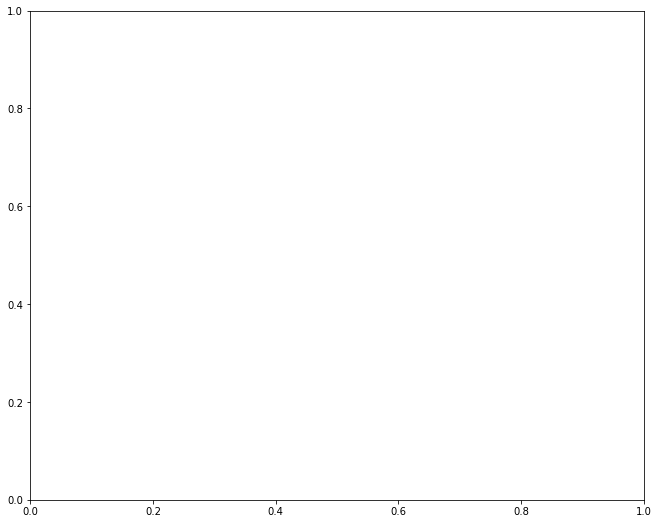

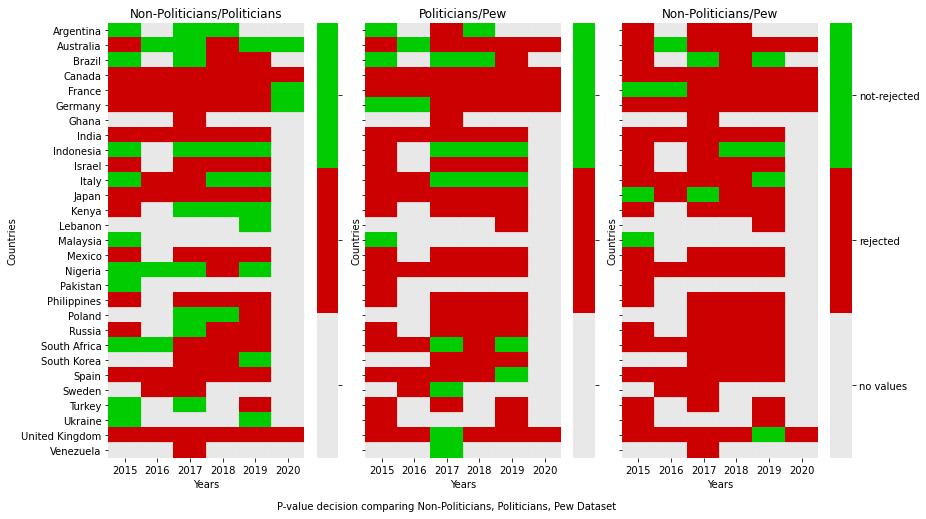

In [153]:
#Create plot
f, ax = plt.subplots(figsize=(11, 9))

#put all 3 dataframes into single list
df_set = [dfs_non_p_p,dfs_p_pew,  dfs_non_p_pew]

#Define colors to get red, green, gray
myColors = ((.9, .9, .9, .9), (0.8, 0.0, 0.0, 1.0),(0.0, 0.8, 0.0, 1.0))
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))
#Define titles foreach subplots
titles = ['Non-Politicians/Politicians', 'Politicians/Pew', 'Non-Politicians/Pew']

fig, ax = plt.subplots(1,3,figsize= (13,7), sharey = True, sharex = True)

for (ind, df) in enumerate(df_set):
    #Create heatmap for 
    axi = sns.heatmap(df.fillna(-1), cmap =cmap, ax=ax[ind])
    #Set colorbar indication
    colorbar = axi.collections[0].colorbar
    colorbar.set_ticks([-0.667, 0, 0.667])
    if ind == (len(df_set) - 1):    
        #if last subplot, add legend to colorbar
        colorbar.set_ticklabels(['no values', 'rejected', 'not-rejected'])
    else :
        colorbar.set_ticklabels(['', '', ''])
    #Set legend
    axi.set_ylabel('Countries')
    axi.set_xlabel('Years')
    axi.set_title(titles[ind])

fig.text(0.3,-0.02, "P-value decision comparing Non-Politicians, Politicians, Pew Dataset")
plt.tight_layout()
plt.savefig("output/pew_heatmap.jpg", dpi=200)

In [23]:
'''
Compute mean of dataframe of each group
Then add a new column containing the number of differents speakers for each country
'''
def compute_mean_spk_count(df, name_group="nationality", name_sent="weighted_sentiment"):
    stats = df.groupby(name_group)[name_sent].agg(['mean'])
    stats['country'] = stats.index
    count_speak = df.groupby(name_group)['speaker_l'].nunique()
    stats['speaker_count'] = count_speak
    return stats

In [24]:
#Store absolute difference of the mean of both datasets (non-pol and pol) for each year
stats_years = [] 
for (ind, df) in enumerate(dfs_new) :

    df_stats_non_p = compute_mean_spk_count(df[~pol_msk])
    df_stats_p = compute_mean_spk_count(df[pol_msk])
    #Merge both dataset
    stats_df = pd.merge(left=df_stats_non_p, right=df_stats_p, 
                        how='outer',
                        left_on='country', right_on='country', 
                        suffixes=('_non_p', '_p'))
    #Add column year
    stats_df['year'] = ind + 2015
    #Compute absolute difference of the mean of both datasets (non-pol and pol)
    stats_df['abs_diff'] = np.abs(stats_df['mean_p'] - stats_df['mean_non_p'])

    stats_years.append(stats_df)
    
final_stats = pd.concat(stats_years)

In [25]:
#Store results
final_stats.to_pickle('data/stats_politicians.pkl.bz2', compression='bz2')
final_stats.to_csv('data/stats_politicians.csv.bz2', compression='bz2')

In [26]:
final_stats[final_stats.year == 2015][['country', 'abs_diff']]

,country,abs_diff
0,Afghanistan,0.060363
1,Albania,0.377667
2,Algeria,0.557833
3,Andorra,NaN
4,Angola,NaN
...,...,...
181,Marshall Islands,NaN
182,Solomon Islands,NaN
183,Timor-Leste,NaN
184,Turkmenistan,NaN


In [27]:
final_stats.columns

Index(['mean_non_p', 'country', 'speaker_count_non_p', 'mean_p',
       'speaker_count_p', 'year', 'abs_diff'],
      dtype='object')